# Preliminaries

Install the needed packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
from dissipationtheory.constants import ureg
from dissipationtheory.dissipation9a import CantileverModel, SampleModel3, SampleModel4
from dissipationtheory.dissipation9b import SampleModel3Jit, SampleModel4Jit

In [3]:
from dissipationtheory.dissipation9e import twodimCobject

In [4]:
THIS = 'dissipation-theory--Study-60--'
figs = {}

# Reproduce the divergence

Set the largest tip-sample separation to 1000 nm below. \
Set the cone length to $10 \times$ this, or 10,000 nm.

In [5]:
cantilever4 = CantileverModel(
    f_c = ureg.Quantity(60, 'kHz'),
    k_c = ureg.Quantity(3.0, 'N/m'), 
    V_ts = ureg.Quantity(1, 'V'), 
    R = ureg.Quantity(30, 'nm'),
    angle = ureg.Quantity(20, 'degree'),
    L = ureg.Quantity(10000, 'nm')
)

sample4 = SampleModel4(
    cantilever = cantilever4,
    z_r = ureg.Quantity(100, 'nm')  # ignored
)

sample4_jit = SampleModel4Jit(**sample4.args())

An array of tip-sample separations.

In [6]:
h_array = np.logspace(np.log10(10), np.log10(1000), 40)
(h_array.min(), h_array.max(), len(h_array))

(10.0, 1000.0, 40)

In [7]:
f2_calc = {}
f2_calc_label = {}

In [8]:
f2_calc_label['A'] = r'$\alpha = 0$'
f2_calc['A'] = np.zeros_like(h_array)
obj = {}

for index, h in enumerate(h_array):
    
    obj[index] = twodimCobject(sample4_jit)
    obj[index].addtip(h=ureg.Quantity(h, 'nm'))
    obj[index].properties()
    f2_calc['A'][index] = np.abs(obj[index].results['Delta f [Hz]'])

In [9]:
def plotme(h_array, f2_calc, f2_calc_label):

    fig, ax = plt.subplots(1, 1, figsize=((3.5,3.5)))
    for key in f2_calc.keys():
        plt.plot(h_array, f2_calc[key], '.-', label=f2_calc_label[key])
    plt.legend(frameon=False)
    ax.set_xlabel('tip-sample separation $h$ [nm]')
    ax.set_ylabel('frequency $\Delta f_2$ [Hz V$^{-2}$]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.tight_layout()
                           
    return fig

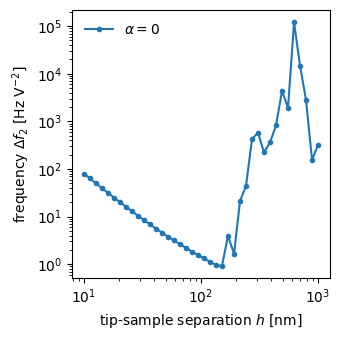

In [10]:
figs['01'] = plotme(h_array, f2_calc, f2_calc_label)

For the closest tip-sample separation, plot all the images charges, then just the first few image charges.

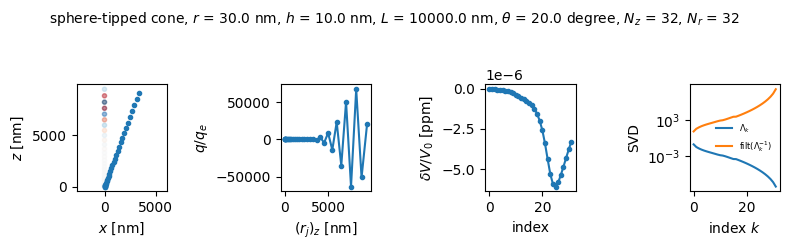

In [11]:
figs['02a'] = obj[0].plot()

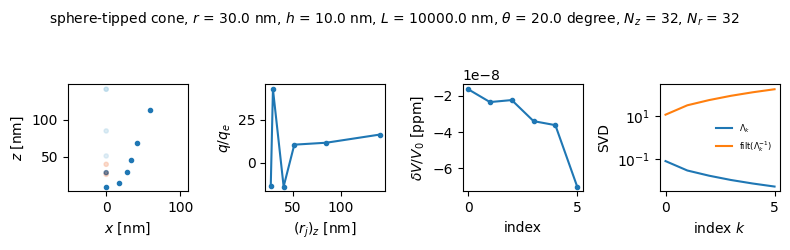

In [12]:
figs['02b'] = obj[0].plot(N=6,M=6)

Repeat at the largest tip-sample separation.

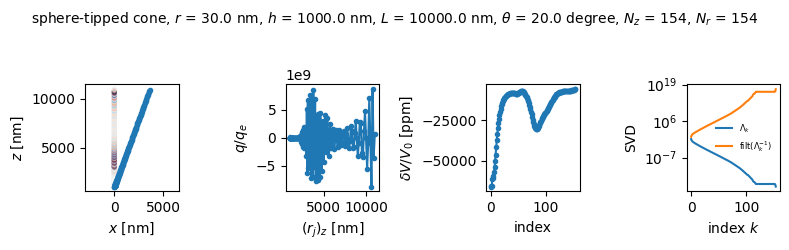

In [13]:
figs['03a'] = obj[39].plot()

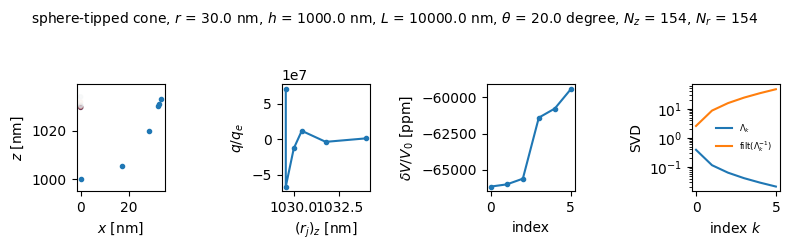

In [14]:
figs['03b'] = obj[39].plot(N=6,M=6)

<span style="color:blue;"><b> The image charges are diverging at large $h$.</b></span>

# Remove the divergence by using a finite $\alpha$ filtering parameter

Play with the $\alpha$ parameter in solve, and look again at the image-charge distribution again. \
Pick $\alpha = 1 \times 10^{-6}$ as a compromise.

In [15]:
obj = {}
for index, h in enumerate(h_array):
    
    obj[index] = twodimCobject(sample4_jit)
    obj[index].addtip(h=ureg.Quantity(h, 'nm'))
    obj[index].solve(0., alpha=1.0e-6)

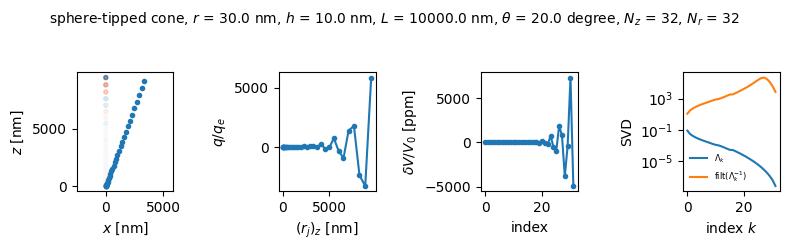

In [16]:
figs['04a'] = obj[0].plot()

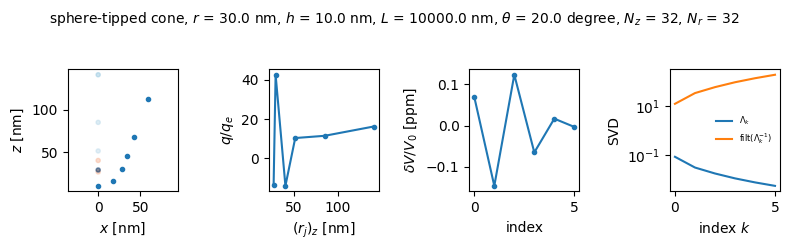

In [17]:
figs['04b'] = obj[0].plot(N=6,M=6)

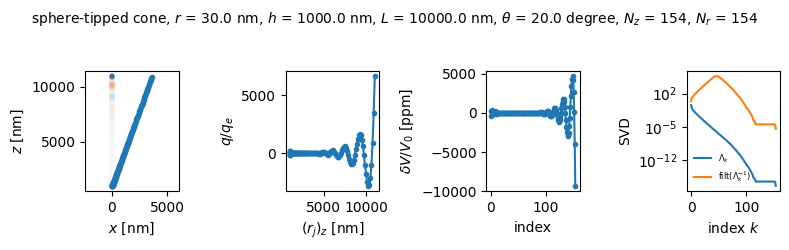

In [18]:
figs['05a'] = obj[39].plot()

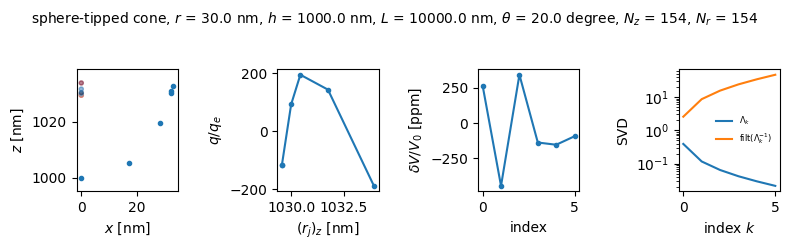

In [19]:
figs['05b'] = obj[39].plot(N=6,M=6)

<span style="color:blue;"><b> We can tame the oscillating leading-edge charges at large $h$ by increasing the $\alpha$ filtering parameter. </b></span>

Modify the `.properties` function to accept and $\alpha$ parameter, passed through to the `.solve` function.

In [20]:
f2_calc_label['B'] = r'$\alpha = 1.0 \times 10^{-6}$'
f2_calc['B'] = np.zeros_like(h_array)
obj = {}

for index, h in enumerate(h_array):
    
    obj[index] = twodimCobject(sample4_jit)
    obj[index].addtip(h=ureg.Quantity(h, 'nm'))
    obj[index].properties(alpha=1.0e-6)
    f2_calc['B'][index] = np.abs(obj[index].results['Delta f [Hz]'])

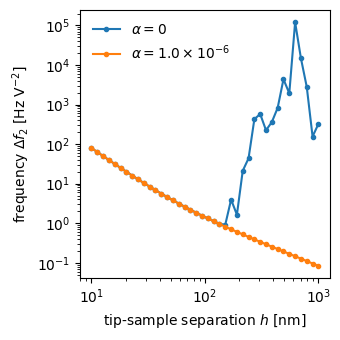

In [21]:
figs['06'] = plotme(h_array, f2_calc, f2_calc_label)

How much has the answer changed?  Plot the absolute difference.

In [22]:
f2_calc_label['C'] = 'absolute difference'
f2_calc['C'] = np.abs(f2_calc['A'] - f2_calc['B'])

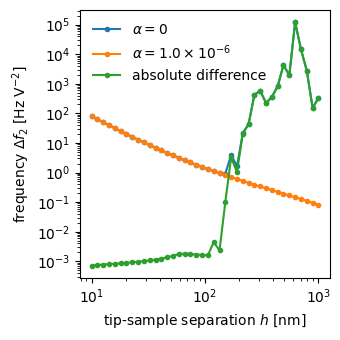

In [23]:
figs['07'] = plotme(h_array, f2_calc, f2_calc_label)

Now plot the relative difference, treating the $\alpha = 1.0 \times 10^{-6}$ data as the ground truth.

In [24]:
f2_calc_label['C'] = 'relative difference'
f2_calc['C'] = np.abs((f2_calc['A'] - f2_calc['B'])/f2_calc['B'])

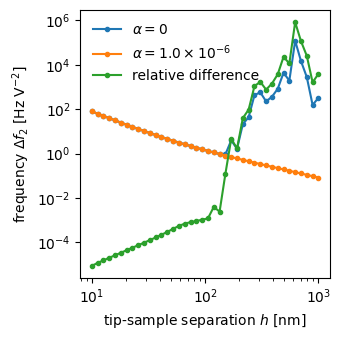

In [25]:
figs['08'] = plotme(h_array, f2_calc, f2_calc_label)

Not much!  With a modest $\alpha = 1.0 \times 10^{-6}$ we can tame the frequency divergence at large $h$ while changing the calculated frequency shift by a tiny amount.  By "tiny" I mean a relative error of $10^{-5}$ at small $h$ and maybe $10^{-2}$ at large $h$.  This error is within the signal-to-noise ratio of the data, so will not affect fit results.

<span style="color:blue;"><b> We can tame the image-charge oscillations at large $h$ using filtering parameter, $\alpha = 1 \times 10^{-6}$. This filtering changes the calculated frequency by a negligible amount.</b></span>

::: {.content-hidden when-format="html"}

# Save the figures

In [26]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-60.ipynb && open dissipation-theory--Study-60.html
    
:::